# Universal Approximation Theorem

In this notebook we show some fleshed out examples of the Universal Approximation Theorem. See the [notes](../notes/14%20-%20Universal%20Appproximation%20Theorem.pdf) for more details.

### Approximation with step functions

First, we show that a step function can approximate any continuous function. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook
%matplotlib widget

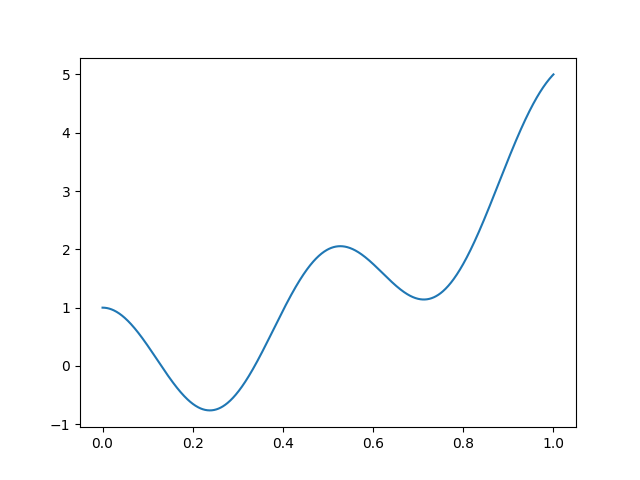

In [2]:
# define f 
def f(x):
    return 4*x**2 + np.cos(2*2*np.pi*x)
  
# plot f 
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(0, 1, 1000)
ax.plot(x, f(x))
plt.show()

We define a class to build step functions. It has an `interpolate` method that takes a function and a number of steps, and returns a step function that approximates the function.

In [3]:
class Step():
  
  def __init__(self, step_points, step_heights):
    self.step_points = step_points
    self.step_heights = step_heights
    
  def __call__(self, x):
    x = np.array(x)
    return np.sum([ (x >= self.step_points[i])*(x < self.step_points[i+1])*self.step_heights[i] for i in range(len(self.step_points)-1) ], axis=0) + (x >= self.step_points[-1])*self.step_heights[-1]
  
  def interpolate(self, f):
    self.step_heights = [f(p) for p in self.step_points]

In [4]:
def plot_approximation(n_steps):
    step_points = np.linspace(0,1,n_steps+1)
    step_heights = np.zeros(n_steps)
    step_f = Step(step_points, step_heights)
    step_f.interpolate(f)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.linspace(0, 1, 1000)
    ax.plot(x, f(x))
    ax.plot(x, step_f(x))
    plt.show()
    error = np.max(np.abs(f(x) - step_f(x)))
    print(error)
    
widgets.interact(plot_approximation, n_steps=widgets.IntSlider(min=1, max=500, step=1, value=1))

interactive(children=(IntSlider(value=1, description='n_steps', max=500, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_approximation(n_steps)>

### Approximating a step function with a sigmoid

Using suitable parameters, a sigmoid can approximate a step function

In [5]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def plot_scaled_sigmoid(w, b, d):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_ylim(-0.1, 2.1)
  x = np.linspace(-10, 10, 1000)
  ax.plot(x, d*sigmoid(w*(x - b)))
  plt.show()

widgets.interact(plot_scaled_sigmoid, w=widgets.FloatSlider(min=-20, max=20, step=1, value=1), b=widgets.FloatSlider(min=-10, max=10, step=0.1, value=0), d=widgets.FloatSlider(min=0, max=2, step=0.1, value=1))

interactive(children=(FloatSlider(value=1.0, description='w', max=20.0, min=-20.0, step=1.0), FloatSlider(valu…

<function __main__.plot_scaled_sigmoid(w, b, d)>

In the next widget, one can try to tune the parameters of the sigmoid functions to approximate the given function f(x).

In [6]:
from ipywidgets import interactive, VBox, HBox

def sigmoid_approx(x, w1s, b1s, w2s, b2):
  return np.sum([sigmoid(x * w1 + b1) * w2 for w1, b1, w2 in zip(w1s, b1s, w2s)], axis=0) + b2

def interactive_sigmoid(n_steps=2):
  sliders = {}
  for i in range(n_steps):
    sliders[f"w1{i+1}"] = widgets.FloatSlider(value=0.0, min=-20.0, max=20.0, step=0.1, description=f"w1{i+1}")
    sliders[f"b1{i+1}"] = widgets.FloatSlider(value=0.0, min=-10.0, max=10.0, step=0.1, description=f"b1{i+1}")
    sliders[f"w2{i+1}"] = widgets.FloatSlider(value=0.0, min=-20.0, max=20.0, step=0.1, description=f"w2{i+1}")
  sliders["b2"] = widgets.FloatSlider(value=0.0, min=-10.0, max=10.0, step=0.1, description="b2")
  
  def update_plot(**kwargs):
    w1s = [kwargs[f"w1{i+1}"] for i in range(n_steps)]
    b1s = [kwargs[f"b1{i+1}"] for i in range(n_steps)]
    w2s = [kwargs[f"w2{i+1}"] for i in range(n_steps)]
    b2 = kwargs["b2"]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_ylim(-1, 5.1)
    x = np.linspace(0, 1, 500)
    y = sigmoid_approx(x, w1s, b1s, w2s, b2)
    ax.plot(x, f(x), label="f(x)")
    ax.plot(x, y, label="Sigmoid Approximation")
    ax.legend()
    plt.show()
  
  interactive_plot = interactive(update_plot, **sliders)
  
  slider_box = VBox([sliders[f"w1{i+1}"] for i in range(n_steps)] +
                    [sliders[f"b1{i+1}"] for i in range(n_steps)] +
                    [sliders[f"w2{i+1}"] for i in range(n_steps)] +
                    [sliders["b2"]])
  
  ui = HBox([interactive_plot.children[-1], slider_box]) 
  return ui

n_steps = 5
plot_widget = interactive_sigmoid(n_steps)
plot_widget

Or, we can use our `mydl` library to train a neural network to approximate the function.

In [7]:
%cd .. 
from mydl.architecture import * # import all the classes and functions from the architecture module
from mydl.layers import * # import all the classes and functions from the layers module
from mydl.losses import * # import all the classes and functions from the losses module
from mydl.optimizers import * # import all the classes and functions from the optimizers module
%cd notebooks

/Users/orlando/GitHub/SCUDO-MMinDL
/Users/orlando/GitHub/SCUDO-MMinDL/notebooks


/Users/orlando/GitHub/SCUDO-MMinDL/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Let us prepare the data.

In [8]:
x = np.linspace(0, 1, 1000) 
y = f(x) 
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [9]:
model = Sequential([Linear(1, 5), 
                    Sigmoid(), 
                    Linear(5, 1)])
loss = MSE()

In [10]:
optimizer = GD(learning_rate=0.01)
losses = model.train(x, y, loss, optimizer, n_epochs=10_000)

Training the network...
Training complete.


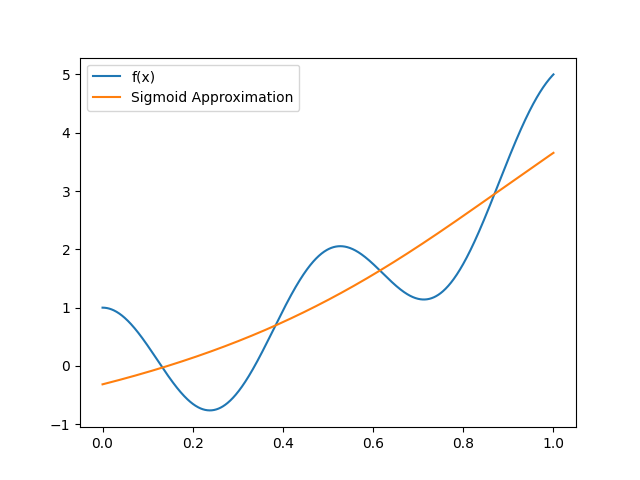

In [11]:
y_pred = model.forward(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), f(x.detach().numpy()), label='f(x)')
ax.plot(x.detach().numpy(), y_pred.detach().numpy(), label='Sigmoid Approximation')
ax.legend()

Let's try a slightly more complex model.

In [12]:
model = Sequential([Linear(1, 10), 
                    Sigmoid(), 
                    Linear(10, 5),
                    Sigmoid(),
                    Linear(5, 1)])
loss = MSE()

In [13]:
optimizer = GD(learning_rate=0.1)
losses = model.train(x, y, loss, optimizer, n_epochs=10_000)

Training the network...
Training complete.


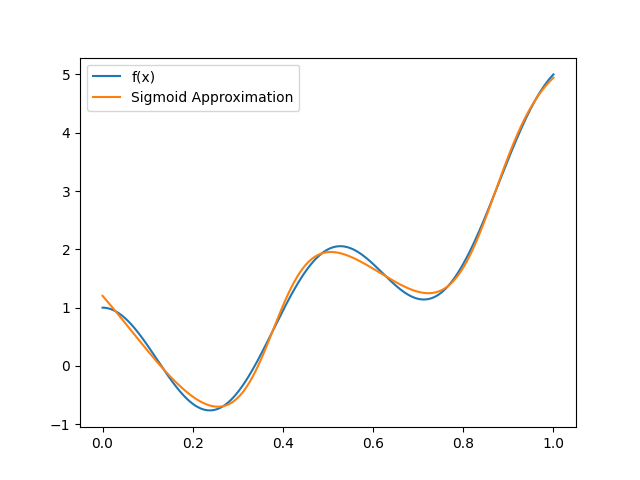

In [14]:
y_pred = model.forward(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), f(x.detach().numpy()), label='f(x)')
ax.plot(x.detach().numpy(), y_pred.detach().numpy(), label='Sigmoid Approximation')
ax.legend()

### 2d case

Let's see how we can approximate a 2d function with a neural network.

First of all: we can use a neural network to approximate a step function in 2d. Try to set these parameters in the interactive plot:
- `w11 = 100`
- `w21 = 20`
- `b11 = 50`
- `w12 = 100`
- `w22 = -20`
- `b12 = -50`
- `w13 = 100`
- `w23 = 20`
- `b13 = 50`
- `w14 = 100`
- `w24 = -20`
- `b14 = -50`
- `b2 = -30`

In [15]:
def two_dimensional_plot(w11, w12, w13, w14, b11, b12, b13, b14, w21, w22, w23, w24, b2):
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  X, Y = np.meshgrid(x, y)
  Z = sigmoid(w21*sigmoid(w11*X + b11) + w22*sigmoid(w12*X + b12) + w23*sigmoid(w13*Y + b13) + w24*sigmoid(w14*Y + b14) + b2)
  
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_zlim(0, 1)
  ax.plot_surface(X, Y, Z, cmap='viridis')
  plt.show()

widgets.interact(two_dimensional_plot, w11=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w12=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w13=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w14=widgets.FloatSlider(min=-100, max=100, step=10, value=0), b11=widgets.FloatSlider(min=-100, max=100, step=10, value=0), b12=widgets.FloatSlider(min=-100, max=100, step=10, value=0), b13=widgets.FloatSlider(min=-100, max=100, step=10, value=0), b14=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w21=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w22=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w23=widgets.FloatSlider(min=-100, max=100, step=10, value=0), w24=widgets.FloatSlider(min=-100, max=100, step=10, value=0), b2=widgets.FloatSlider(min=-100, max=100, step=10, value=0))

interactive(children=(FloatSlider(value=0.0, description='w11', min=-100.0, step=10.0), FloatSlider(value=0.0,…

<function __main__.two_dimensional_plot(w11, w12, w13, w14, b11, b12, b13, b14, w21, w22, w23, w24, b2)>

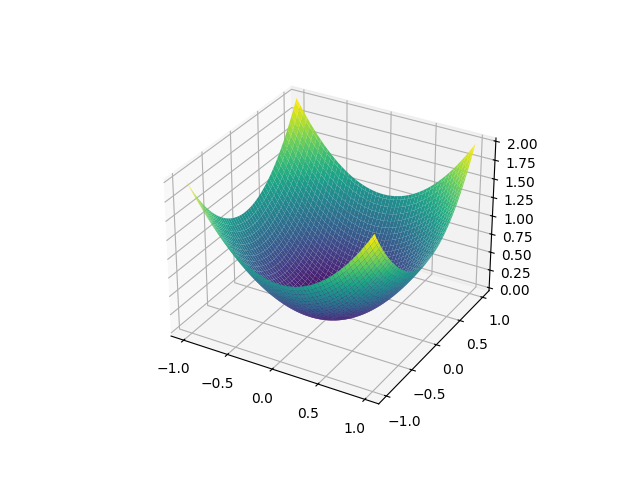

In [16]:
def g(x):
  return x[0]**2 + x[1]**2

# plot g
x0 = np.linspace(-1, 1, 100)
x1 = np.linspace(-1, 1, 100)
X0, X1 = np.meshgrid(x0, x1)
Y = g([X0, X1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, X1, Y, cmap='viridis')
plt.show()

In [17]:
# create train data
x_train = np.random.uniform(-1, 1, (10_000, 2))
y_train = np.array([g(x) for x in x_train])
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

x_train.shape, y_train.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [18]:
layers = [Linear(2, 50), 
          Sigmoid(), 
          Linear(50, 1)]
model = Sequential(layers)
loss = MSE()

In [19]:
optimizer = GD(learning_rate=0.05)
losses = model.train(x_train, y_train, loss, optimizer, n_epochs=1_000)

Training the network...
Training complete.


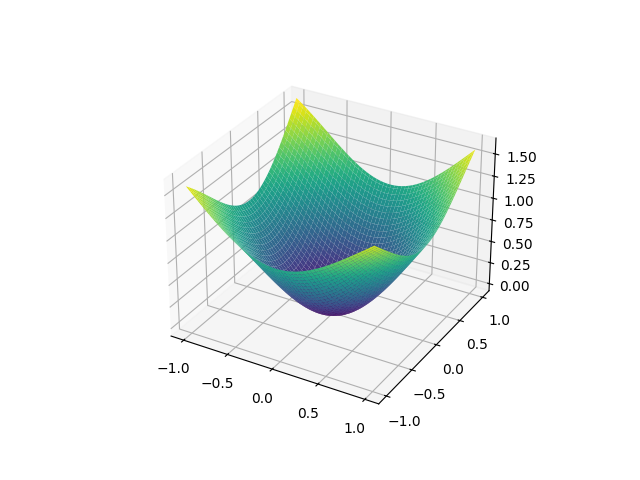

In [20]:
x0 = np.linspace(-1, 1, 100)
x1 = np.linspace(-1, 1, 100)
X0, X1 = np.meshgrid(x0, x1)
x = torch.tensor(np.array([X0, X1]).reshape(2, -1).T, dtype=torch.float32)
y = model.forward(x).detach().numpy().reshape(100, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, X1, y, cmap='viridis')
plt.show()